##### Import pytorch geometric libraries to create graph structure of molecules 

In [146]:
#!pip install networkx
#!pip install torch-scatter==2.0.9 -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
#!pip install torch-sparse==0.6.13 -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
#!pip install torch-geometric==2.0.2 -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
#!pip install torch==1.10.0+cu111 -f https://download.pytorch.org/whl/cu111/torch_stable.html
#!pip install decorator==5.0.9

In [1]:
import torch.nn as nn
import numpy as np
import torch
from torch_geometric.datasets import QM9
from torch_geometric.loader import DataLoader
from torch_geometric.nn import NNConv, global_add_pool
import torch.nn.functional as F
import pickle

In [41]:
### added for testing
with open('smilesDataNew.pkl', 'rb') as f:
    data_list = pickle.load(f)

In [42]:
### added for testing
#with open('geometricData.pkl', 'rb') as f:
#    data_list = pickle.load(f)

In [43]:
print(data_list[0])


Data(x=[20, 79], edge_index=[2, 40], edge_attr=[40, 10], y=[1])


In [44]:
#It is deep chem data
#dset = QM9('.') 
#data = dset[8]
#print(f'Total number of molecules : \n{len(dset)}\n')
#print(f'Graph representation of molecule : \n{data}\n')
#print(f'Edge matrix : \n{data.edge_attr}\n')

# the atomic number of each atom can add attributes
#data.new_attribute = torch.tensor([1, 2, 3]) 
#print(f'Graph representation of molecule with new attributes : \n{data}\n')

# can move all attributes between devices
#device = torch.device(
#    "cuda:0" if torch.cuda.is_available() else "cpu"
#)
#data.to(device)

#print(f'Is the data new attribute is moved to cude : \n{data.new_attribute.is_cuda}\n')

In [83]:
class ExampleNet(torch.nn.Module):
    def __init__(self, num_node_features, num_edge_features):
        super().__init__()
        conv1_net = nn.Sequential(
            nn.Linear(num_edge_features, 32),
            nn.ReLU(),
            nn.Linear(32, num_node_features*32))
        conv2_net = nn.Sequential(
            nn.Linear(num_edge_features, 32),
            nn.ReLU(),
            nn.Linear(32, 32*16))
        self.conv1 = NNConv(num_node_features, 32, conv1_net)
        self.conv2 = NNConv(32,16, conv2_net)
        self.fc_1 = nn.Linear(16, 32)
        self.out = nn.Linear(32, 1)
    def forward(self, data):
        batch, x, edge_index, edge_attr = (
            data.batch, data.x, data.edge_index, data.edge_attr)
        # First graph conv layer
        #print(x[0].item())
        x = F.relu(self.conv1(x, edge_index, edge_attr).float())
        # Second graph conv layer
        x = F.relu(self.conv2(x, edge_index, edge_attr).float())
        x = global_add_pool(x,batch)
        x = F.relu(self.fc_1(x))
        #output = F.log_softmax(self.out(x), dim=1)
        output = torch.sigmoid(self.out(x))
        
        #output = self.out(x)
        return output

#### We divide the QM9 molecule dataset in train, test and validation dataset

In [84]:
y_custom = []
for i in range(0, len(data_list)):
    #print('hi')
    y_custom.append(data_list[i].y.item())
y_custom = np.asarray(y_custom)

In [85]:
values, counts = np.unique(y_custom, return_counts=True)
print(values)
print(counts)

[0. 1.]
[192124   1590]


In [86]:
from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(data_list, y_custom, stratify=y_custom, test_size = 0.2, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(data_list, y_custom, stratify=y_custom, test_size = 0.1, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

#train_set, valid_set, test_set = random_split(
#    data_list,[15000, 2000 , 2128])
trainloader = DataLoader(X_train, batch_size=256, shuffle=True)
validloader = DataLoader(X_val, batch_size=int(len(y_val)/10), shuffle=True)
testloader = DataLoader(X_test, batch_size=256, shuffle=True)
len(y_train)/10


13075.6

In [87]:
#from torch.utils.data import random_split
#train_set, valid_set, test_set = random_split(
#    dset,[110000, 10831, 10000])
#trainloader = DataLoader(train_set, batch_size=32, shuffle=True)
#validloader = DataLoader(valid_set, batch_size=32, shuffle=True)
#testloader = DataLoader(test_set, batch_size=32, shuffle=True)


##### Initialize the network

In [88]:

#qm9_node_feats, qm9_edge_feats = 11, 4
#qm9_node_feats, qm9_edge_feats = 9, 3
qm9_node_feats, qm9_edge_feats = 79, 10
net = ExampleNet(qm9_node_feats, qm9_edge_feats)
# initialize an optimizer with some reasonable parameters
optimizer = torch.optim.Adam(
    net.parameters(), lr=0.001)
epochs = 100
target_idx = 1 # index position of the polarizability label
device = torch.device("cuda:0" if
                      torch.cuda.is_available() else "cpu")
net.to(device)
criterion = nn.BCELoss()

##### Training the network

In [89]:
loss_list = []
valloss_list = []
val_acc_list = []
for total_epochs in range(epochs):
    epoch_loss = 0
    total_graphs = 0
    net.train()
    train_avg_loss = 0
    val_avg_loss = 0
    val_acc = 0
    for batch in trainloader:
        batch.to(device)
        optimizer.zero_grad()
        output = net(batch)
        loss = criterion(output,batch.y.unsqueeze(1))
        #loss = F.mse_loss(
            #output,batch.y[:,target_idx].unsqueeze(1))
           # output,batch.y.unsqueeze(1))
        loss.backward()
        epoch_loss += loss.item()
        #print(epoch_loss)
        total_graphs += batch.num_graphs
        optimizer.step()
    train_avg_loss = epoch_loss / total_graphs
    #print(train_avg_loss)
    if total_epochs % 10 == 0:
        
        val_loss = 0
        total_graphs = 0   
        net.eval()
        predictions = []
        real = []
        for batch in validloader:
            batch.to(device)
            #print('hee')
            output = net(batch)
            loss = criterion(output,batch.y.unsqueeze(1))
            #loss = F.mse_loss(
            #    #output,batch.y[:,target_idx].unsqueeze(1))
            #    output,batch.y.unsqueeze(1))
            val_loss += loss.item()
            total_graphs += batch.num_graphs

            prediction = output.detach().cpu().numpy()
            predictions.append(prediction)
            real.append(batch.y.detach().cpu().numpy())
        real = np.concatenate(real)
        predictions = np.concatenate(predictions)
        predictions = (predictions>0.01)
        #error = 0
        errorCount = 0
        #print('here')
        for i in range(len(predictions)):
            errorCount = errorCount + abs(predictions[i]-real[i])
        #print('he')
        val_acc = ((len(predictions) - errorCount)/len(predictions))*100
        #val_acc = 100 - ((predictions - real)/len(predictions))*100
        val_avg_loss = val_loss / total_graphs
        #print(val_acc[0])
        valloss_list.append(val_avg_loss)
        val_acc_list.append(val_acc)
        loss_list.append(train_avg_loss)
        #if total_epochs % 10 == 0:
        print(f"Epochs: {total_epochs} | "
            f"epoch avg. loss: {train_avg_loss:.2f} | "
            f"validation avg. loss: {val_avg_loss:.2f} |"
            f"validation acc.: {val_acc[0]:.2f}")


Epochs: 0 | epoch avg. loss: 0.00 | validation avg. loss: 0.00 |validation acc.: 60.87
Epochs: 10 | epoch avg. loss: 0.00 | validation avg. loss: 0.00 |validation acc.: 62.77
Epochs: 20 | epoch avg. loss: 0.00 | validation avg. loss: 0.00 |validation acc.: 77.11
Epochs: 30 | epoch avg. loss: 0.00 | validation avg. loss: 0.00 |validation acc.: 72.12
Epochs: 40 | epoch avg. loss: 0.00 | validation avg. loss: 0.00 |validation acc.: 90.48
Epochs: 50 | epoch avg. loss: 0.00 | validation avg. loss: 0.00 |validation acc.: 83.57
Epochs: 60 | epoch avg. loss: 0.00 | validation avg. loss: 0.00 |validation acc.: 91.27
Epochs: 70 | epoch avg. loss: 0.00 | validation avg. loss: 0.00 |validation acc.: 87.67
Epochs: 90 | epoch avg. loss: 0.00 | validation avg. loss: 0.00 |validation acc.: 92.49


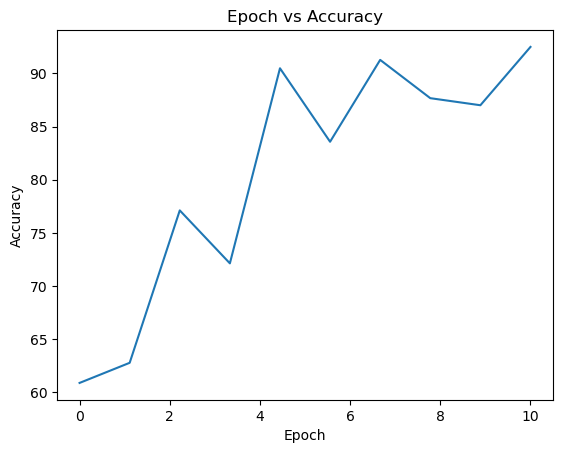

In [90]:
import matplotlib.pyplot as plt
step = np.linspace(0,10, 10)
plt.plot(step,np.array(val_acc_list))
# Add title and axis names
plt.title('Epoch vs Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
  
# Show graph
plt.show()

In [ ]:
import pickle
with open('gnnValAcc.pkl', 'wb') as f:
    pickle.dump(val_acc_list, f)

with open('gnnValloss.pkl', 'wb') as f:
    pickle.dump(valloss_list, f)

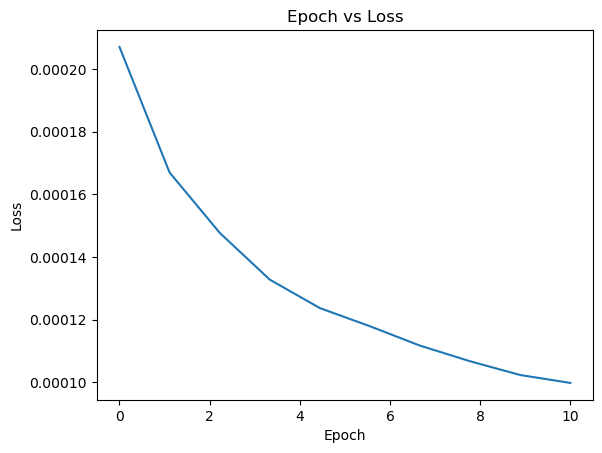

In [93]:
import matplotlib.pyplot as plt
step = np.linspace(0,10, 10)
plt.plot(step,np.array(loss_list))

# Add title and axis names
plt.title('Epoch vs Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
  
# Show graph
plt.show()

##### Predicting ouput

In [128]:
net.eval()
predictions = []
real = []
for batch in testloader:
    output = net(batch.to(device))
    prediction = output.detach().cpu().numpy()
    predictions.append(prediction)
    #print(prediction)
    real.append(
        batch.y.detach().cpu().numpy())
real = np.concatenate(real)
predictions = np.concatenate(predictions)

In [129]:
predictions = np.sort(predictions)

In [130]:
#print(predictions[19362:19372])
#print(predictions[0:10])
predictions = (predictions>0.008)
#print(predictions)

In [131]:
unique, counts = np.unique(predictions, return_counts=True)
print(f'Actual Unique values for testing data: {unique}')
print(f'Actual Count of zeros and ones for testing data: {counts}')

Actual Unique values for testing data: [False  True]
Actual Count of zeros and ones for testing data: [17437  1935]


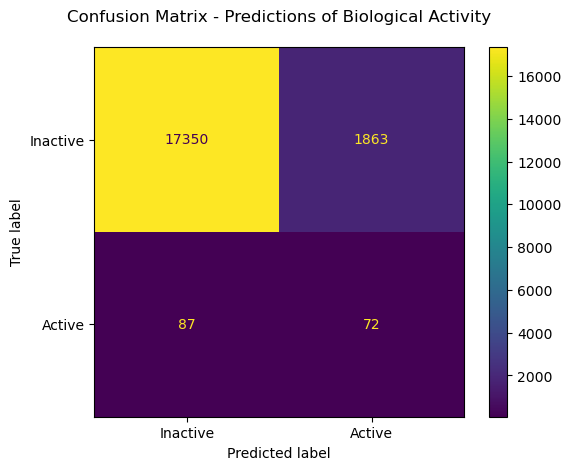

In [132]:
import matplotlib.pyplot as plt
plt.style.use('default')

from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(real, predictions, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0, 1])
disp.plot()
plt.yticks(ticks = [0,1], labels=['Inactive', 'Active'])
plt.xticks(ticks = [0,1], labels=['Inactive', 'Active'])
plt.title("Confusion Matrix - Predictions of Biological Activity\n")
plt.show()

#### FFN - to be removed

In [133]:
import torch
import torch.nn as nn # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim # For all Optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F # All functions that don't have any parameters
from torch.utils.data import DataLoader # Gives easier dataset managment and creates mini batches
import torchvision.datasets as datasets # Has standard datasets we can import in a nice and easy way
import torchvision.transforms as transforms # Transformations we can perform on our dataset
from torch.utils.data import TensorDataset
import pandas as pd
import numpy as np
import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split


In [134]:
dataframe_final = pd.read_csv("fingerPrintDataAllChem2048", index_col=False).drop(["Unnamed: 0"], axis =1)
print(f'All data \n{dataframe_final}')

X_dataframe = dataframe_final.iloc[:,:dataframe_final.shape[1]-1]
print(f'\nTrain data \n{X_dataframe}')

y_dataframe = dataframe_final.iloc[:,-1]
print(f'\nLabels \n{y_dataframe}')

X_train, X_test, y_train, y_test = train_test_split(X_dataframe, y_dataframe, stratify=y_dataframe, test_size = 0.2, random_state=42)


batch_size = 256
X_train_torch = torch.from_numpy(X_train.values.astype(np.float32))
y_train_torch = torch.from_numpy(y_train.values.astype(np.float32))
X_test_torch = torch.from_numpy(X_test.values.astype(np.float32))
y_test_torch = torch.from_numpy(y_test.values.astype(np.float32))

train_ds = TensorDataset(X_train_torch, y_train_torch)
train_loader = DataLoader(train_ds, batch_size, shuffle=True)

test_ds = TensorDataset(X_test_torch, y_test_torch)
test_loader = DataLoader(test_ds, batch_size, shuffle=True)

All data 
        0  1  2  3  4  5  6  7  8  9  ...  2039  2040  2041  2042  2043  2044  \
0       1  1  1  1  1  0  0  0  1  0  ...     0     1     1     0     0     0   
1       0  0  0  0  1  0  1  0  0  0  ...     1     0     0     0     0     0   
2       1  0  0  0  1  0  1  0  0  0  ...     0     0     0     0     0     1   
3       0  0  1  0  1  1  1  0  0  0  ...     1     0     0     0     0     0   
4       1  1  1  0  1  1  1  0  0  0  ...     0     1     0     0     0     0   
...    .. .. .. .. .. .. .. .. .. ..  ...   ...   ...   ...   ...   ...   ...   
193709  1  0  1  1  1  0  1  0  0  0  ...     0     0     0     0     0     0   
193710  1  1  1  0  1  0  1  0  1  0  ...     1     1     0     0     0     0   
193711  1  1  1  0  1  0  0  0  1  0  ...     0     1     0     0     0     0   
193712  1  1  1  1  1  0  0  0  0  0  ...     0     1     0     0     0     0   
193713  1  0  1  1  1  1  1  0  0  0  ...     0     1     0     0     0     0   

        2045  204

In [44]:
class NN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)
        self.dout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(1024, 250)
        self.dout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(250, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dout1(x)
        x = F.relu(self.fc2(x))
        x = self.dout2(x)
        x = self.fc3(x)
        return x 

In [138]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = 2048
num_classes = 2
learning_rate = 0.0001
#num_epochs = 50

batch_size = 256
n_iters = 70000
num_epochs = n_iters / (len(train_ds) / batch_size)
num_epochs = int(num_epochs)

model = NN(input_size=input_size, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [139]:
for epoch in range(num_epochs):
    #print(f"Epoch: {epoch}")
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)
        targets=targets.to(torch.int64)

        # forward propagation
        scores = model(data)
        #print(scores)
        loss = criterion(scores, targets)
        
        # zero previous gradients
        optimizer.zero_grad()
        
        # back-propagation
        loss.backward()

        # gradient descent or adam step
        optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}  Loss {loss.item():.4f}')

Epoch 0  Loss 0.0751
Epoch 10  Loss 0.0001
Epoch 20  Loss 0.0000
Epoch 30  Loss 0.0000
Epoch 40  Loss 0.0000
Epoch 50  Loss 0.0000
Epoch 60  Loss 0.0002
Epoch 70  Loss 0.0000
Epoch 80  Loss 0.0000
Epoch 90  Loss 0.0001
Epoch 100  Loss 0.0000
Epoch 110  Loss 0.0000


In [140]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    predictionArr = []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            x = x.reshape(x.shape[0], -1)

            scores = model(x)
            _, predictions1 = scores.max(1)
            predictionArr.append(predictions1)
            num_correct += (predictions1 == y).sum()
            num_samples += predictions1.size(0)

        print(
            f"Got {num_correct} / {num_samples} with accuracy"
            f" {float(num_correct) / float(num_samples) * 100:.2f}"
        )

    model.train()
    return predictionArr


In [141]:
predictions_train = check_accuracy(train_loader, model)
predictions_test = check_accuracy(test_loader, model)


Got 154953 / 154971 with accuracy 99.99
Got 38329 / 38743 with accuracy 98.93


In [142]:
finalTrainPredictions = []
for t,l in enumerate(predictions_train):
    for p in l:
        finalTrainPredictions.append(p.cpu().detach().numpy())
        
finalTestPredictions = []
for t,l in enumerate(predictions_test):
    for p in l:
        finalTestPredictions.append(p.cpu().detach().numpy())

finalTrainPredictions = np.array(finalTrainPredictions)
finalTestPredictions = np.array(finalTestPredictions)


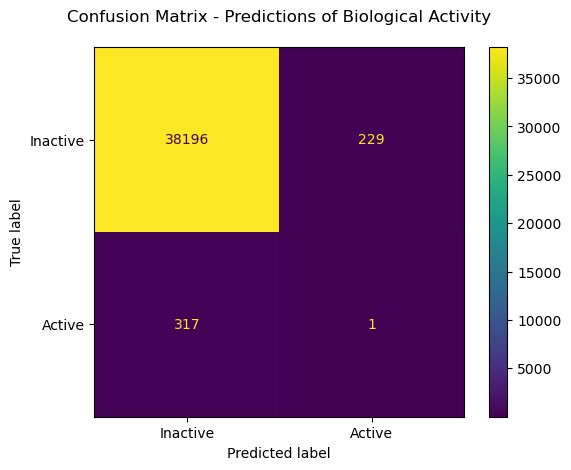

In [143]:

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html
m = np.array(y_test)
import matplotlib.pyplot as plt
plt.style.use('default')

from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(m, finalTestPredictions, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0, 1])
disp.plot()
plt.yticks(ticks = [0,1], labels=['Inactive', 'Active'])
plt.xticks(ticks = [0,1], labels=['Inactive', 'Active'])
plt.title("Confusion Matrix - Predictions of Biological Activity\n")
plt.show()

### SVM

In [144]:
with open('svm_y_predict.pkl', 'rb') as f:
    y_predict = pickle.load(f)
with open('svm_y_test.pkl', 'rb') as f:
    y_actual = pickle.load(f)

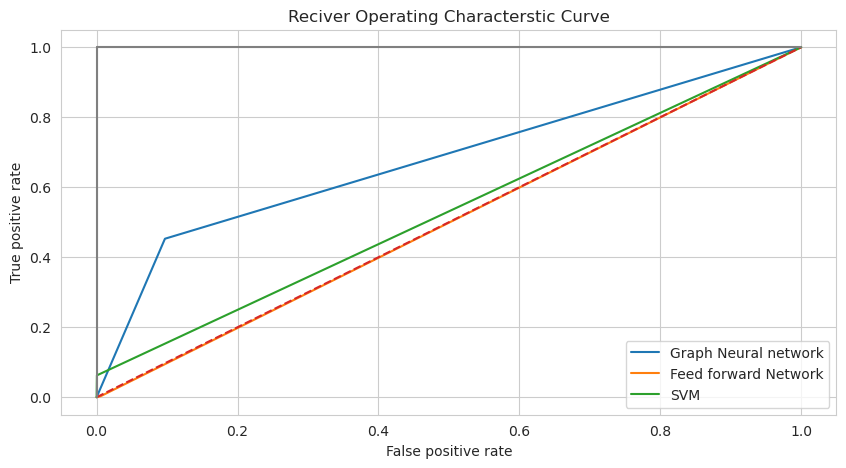

In [145]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics
gnn_false_positive_rate,gnn_true_positive_rate, gnn_threshold = metrics.roc_curve(real,predictions)
ffn_false_positive_rate,ffn_true_positive_rate, ffn_threshold = metrics.roc_curve(m,finalTestPredictions)
svm_false_positive_rate,svm_true_positive_rate, svm_threshold = metrics.roc_curve(y_actual,y_predict)
sns.set_style('whitegrid')
plt.figure(figsize=(10,5))
plt.title('Reciver Operating Characterstic Curve')
plt.plot(gnn_false_positive_rate,gnn_true_positive_rate,label='Graph Neural network')
plt.plot(ffn_false_positive_rate,ffn_true_positive_rate,label='Feed forward Network')
plt.plot(svm_false_positive_rate,svm_true_positive_rate,label='SVM')
#plt.plot(nb_false_positive_rate,nb_true_positive_rate,label='Naive Bayes')
#plt.plot(rf_false_positive_rate,rf_true_positive_rate,label='Random Forest')
#plt.plot(knn_false_positive_rate,knn_true_positive_rate,label='K-Nearest Neighbor')
#plt.plot(dt_false_positive_rate,dt_true_positive_rate,label='Desion Tree')
#plt.plot(svc_false_positive_rate,svc_true_positive_rate,label='Support Vector Classifier')
#plt.plot(sgd_false_positive_rate,sgd_true_positive_rate,label='Stochastic Gradient Descent')
plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.legend()
plt.show()

#### Model comparison for different number of layers:

In [3]:
### added for testing
import pickle
with open('smilesDataNew.pkl', 'rb') as f:
    data_list = pickle.load(f)


In [4]:
class ExampleNet0(torch.nn.Module):
    def __init__(self, num_node_features, num_edge_features):
        super().__init__()
        conv1_net = nn.Sequential(
            nn.Linear(num_edge_features, 32),
            nn.ReLU(),
            nn.Linear(32, num_node_features*32))
        conv2_net = nn.Sequential(
            nn.Linear(num_edge_features, 32),
            nn.ReLU(),
            nn.Linear(32, 32*16))
        self.conv1 = NNConv(num_node_features, 32, conv1_net)
        self.conv2 = NNConv(32,16, conv2_net)
        self.fc_1 = nn.Linear(16, 32)
        self.out = nn.Linear(32, 1)
    def forward(self, data):
        batch, x, edge_index, edge_attr = (
            data.batch, data.x, data.edge_index, data.edge_attr)
        # First graph conv layer
        #print(x[0].item())
        x = F.relu(self.conv1(x, edge_index, edge_attr).float())
        # Second graph conv layer
        x = F.relu(self.conv2(x, edge_index, edge_attr).float())
        x = global_add_pool(x,batch)
        x = F.relu(self.fc_1(x))
        #output = F.log_softmax(self.out(x), dim=1)
        output = torch.sigmoid(self.out(x))
        
        #output = self.out(x)
        return output

In [5]:
class ExampleNet1(torch.nn.Module):
    def __init__(self, num_node_features, num_edge_features):
        super().__init__()
        conv1_net = nn.Sequential(
            nn.Linear(num_edge_features, 32),
            nn.ReLU(),
            nn.Linear(32, num_node_features*32))
        conv2_net = nn.Sequential(
            nn.Linear(num_edge_features, 32),
            nn.ReLU(),
            nn.Linear(32, 32*32))
        conv3_net = nn.Sequential(
            nn.Linear(num_edge_features, 32),
            nn.ReLU(),
            nn.Linear(32, 32*16))
        self.conv1 = NNConv(num_node_features, 32, conv1_net)
        self.conv2 = NNConv(32,32, conv2_net)
        self.conv3 = NNConv(32,16, conv3_net)
        self.fc_1 = nn.Linear(16, 32)
        self.out = nn.Linear(32, 1)
    def forward(self, data):
        batch, x, edge_index, edge_attr = (
            data.batch, data.x, data.edge_index, data.edge_attr)
        # First graph conv layer
        #print(x[0].item())
        x = F.relu(self.conv1(x, edge_index, edge_attr).float())
        # Second graph conv layer
        x = F.relu(self.conv2(x, edge_index, edge_attr).float())
        x = F.relu(self.conv3(x, edge_index, edge_attr).float())
        x = global_add_pool(x,batch)
        x = F.relu(self.fc_1(x))
        #output = F.log_softmax(self.out(x), dim=1)
        output = torch.sigmoid(self.out(x))
        
        #output = self.out(x)
        return output

In [6]:
class ExampleNet2(torch.nn.Module):
    def __init__(self, num_node_features, num_edge_features):
        super().__init__()
        conv1_net = nn.Sequential(
            nn.Linear(num_edge_features, 32),
            nn.ReLU(),
            nn.Linear(32, num_node_features*32))
        conv2_net = nn.Sequential(
            nn.Linear(num_edge_features, 32),
            nn.ReLU(),
            nn.Linear(32, 32*32))
        conv3_net = nn.Sequential(
            nn.Linear(num_edge_features, 32),
            nn.ReLU(),
            nn.Linear(32, 32*32))
        conv4_net = nn.Sequential(
            nn.Linear(num_edge_features, 32),
            nn.ReLU(),
            nn.Linear(32, 32*16))
        self.conv1 = NNConv(num_node_features, 32, conv1_net)
        self.conv2 = NNConv(32,32, conv2_net)
        self.conv3 = NNConv(32,32, conv3_net)
        self.conv4 = NNConv(32,16, conv4_net)
        self.fc_1 = nn.Linear(16, 32)
        self.out = nn.Linear(32, 1)
    def forward(self, data):
        batch, x, edge_index, edge_attr = (
            data.batch, data.x, data.edge_index, data.edge_attr)
        # First graph conv layer
        #print(x[0].item())
        x = F.relu(self.conv1(x, edge_index, edge_attr).float())
        # Second graph conv layer
        x = F.relu(self.conv2(x, edge_index, edge_attr).float())
        x = F.relu(self.conv3(x, edge_index, edge_attr).float())
        x = F.relu(self.conv4(x, edge_index, edge_attr).float())
        x = global_add_pool(x,batch)
        x = F.relu(self.fc_1(x))
        #output = F.log_softmax(self.out(x), dim=1)
        output = torch.sigmoid(self.out(x))
        
        #output = self.out(x)
        return output

In [7]:
class ExampleNet3(torch.nn.Module):
    def __init__(self, num_node_features, num_edge_features):
        super().__init__()
        conv1_net = nn.Sequential(
            nn.Linear(num_edge_features, 32),
            nn.ReLU(),
            nn.Linear(32, num_node_features*32))
        conv2_net = nn.Sequential(
            nn.Linear(num_edge_features, 32),
            nn.ReLU(),
            nn.Linear(32, 32*32))
        conv3_net = nn.Sequential(
            nn.Linear(num_edge_features, 32),
            nn.ReLU(),
            nn.Linear(32, 32*32))
        conv4_net = nn.Sequential(
            nn.Linear(num_edge_features, 32),
            nn.ReLU(),
            nn.Linear(32, 32*32))
        conv5_net = nn.Sequential(
            nn.Linear(num_edge_features, 32),
            nn.ReLU(),
            nn.Linear(32, 32*16))
        self.conv1 = NNConv(num_node_features, 32, conv1_net)
        self.conv2 = NNConv(32,32, conv2_net)
        self.conv3 = NNConv(32,32, conv3_net)
        self.conv4 = NNConv(32,32, conv4_net)
        self.conv5 = NNConv(32,16, conv5_net)
        self.fc_1 = nn.Linear(16, 32)
        self.out = nn.Linear(32, 1)
    def forward(self, data):
        batch, x, edge_index, edge_attr = (
            data.batch, data.x, data.edge_index, data.edge_attr)
        # First graph conv layer
        #print(x[0].item())
        x = F.relu(self.conv1(x, edge_index, edge_attr).float())
        # Second graph conv layer
        x = F.relu(self.conv2(x, edge_index, edge_attr).float())
        x = F.relu(self.conv3(x, edge_index, edge_attr).float())
        x = F.relu(self.conv4(x, edge_index, edge_attr).float())
        x = F.relu(self.conv5(x, edge_index, edge_attr).float())
        x = global_add_pool(x,batch)
        x = F.relu(self.fc_1(x))
        #output = F.log_softmax(self.out(x), dim=1)
        output = torch.sigmoid(self.out(x))
        
        #output = self.out(x)
        return output

In [8]:
class ExampleNet4(torch.nn.Module):
    def __init__(self, num_node_features, num_edge_features):
        super().__init__()
        conv1_net = nn.Sequential(
            nn.Linear(num_edge_features, 32),
            nn.ReLU(),
            nn.Linear(32, num_node_features*32))
        conv2_net = nn.Sequential(
            nn.Linear(num_edge_features, 32),
            nn.ReLU(),
            nn.Linear(32, 32*32))
        conv3_net = nn.Sequential(
            nn.Linear(num_edge_features, 32),
            nn.ReLU(),
            nn.Linear(32, 32*32))
        conv4_net = nn.Sequential(
            nn.Linear(num_edge_features, 32),
            nn.ReLU(),
            nn.Linear(32, 32*32))
        conv5_net = nn.Sequential(
            nn.Linear(num_edge_features, 32),
            nn.ReLU(),
            nn.Linear(32, 32*32))
        conv6_net = nn.Sequential(
            nn.Linear(num_edge_features, 32),
            nn.ReLU(),
            nn.Linear(32, 32*16))
        self.conv1 = NNConv(num_node_features, 32, conv1_net)
        self.conv2 = NNConv(32,32, conv2_net)
        self.conv3 = NNConv(32,32, conv3_net)
        self.conv4 = NNConv(32,32, conv4_net)
        self.conv5 = NNConv(32,32, conv5_net)
        self.conv6 = NNConv(32,16, conv6_net)
        self.fc_1 = nn.Linear(16, 32)
        self.out = nn.Linear(32, 1)
    def forward(self, data):
        batch, x, edge_index, edge_attr = (
            data.batch, data.x, data.edge_index, data.edge_attr)
        # First graph conv layer
        #print(x[0].item())
        x = F.relu(self.conv1(x, edge_index, edge_attr).float())
        # Second graph conv layer
        x = F.relu(self.conv2(x, edge_index, edge_attr).float())
        x = F.relu(self.conv3(x, edge_index, edge_attr).float())
        x = F.relu(self.conv4(x, edge_index, edge_attr).float())
        x = F.relu(self.conv5(x, edge_index, edge_attr).float())
        x = F.relu(self.conv6(x, edge_index, edge_attr).float())
        x = global_add_pool(x,batch)
        x = F.relu(self.fc_1(x))
        #output = F.log_softmax(self.out(x), dim=1)
        output = torch.sigmoid(self.out(x))
        
        #output = self.out(x)
        return output

In [9]:
y_custom = []
for i in range(0, len(data_list)):
    #print('hi')
    y_custom.append(data_list[i].y.item())
y_custom = np.asarray(y_custom)

from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(data_list, y_custom, stratify=y_custom, test_size = 0.2, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(data_list, y_custom, stratify=y_custom, test_size = 0.1, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

#train_set, valid_set, test_set = random_split(
#    data_list,[15000, 2000 , 2128])
trainloader = DataLoader(X_train, batch_size=256, shuffle=True)
validloader = DataLoader(X_val, batch_size=int(len(y_val)/10), shuffle=True)
testloader = DataLoader(X_test, batch_size=256, shuffle=True)


In [10]:
qm9_node_feats, qm9_edge_feats = 79, 10
netList = []
layers = 2
net1 = ExampleNet0(qm9_node_feats, qm9_edge_feats)
netList.append(net1)
net2 = ExampleNet1(qm9_node_feats, qm9_edge_feats)
netList.append(net2)
net3 = ExampleNet2(qm9_node_feats, qm9_edge_feats)
netList.append(net3)
net4 = ExampleNet3(qm9_node_feats, qm9_edge_feats)
netList.append(net4)
net5 = ExampleNet4(qm9_node_feats, qm9_edge_feats)
netList.append(net5)

# initialize an optimizer with some reasonable parameters
optimizer = []
for i in range(0,5):
    optimizer.append(torch.optim.Adam(
        netList[i].parameters(), lr=0.001))
epochs = 100
target_idx = 1 # index position of the polarizability label
device = torch.device("cuda:0" if
                      torch.cuda.is_available() else "cpu")
for i in range(0,5):
    netList[i].to(device)
criterion = nn.BCELoss()

In [11]:
testAccList = []
for i in range(0,5):
    loss_list = []
    valloss_list = []
    val_acc_list = []
    for total_epochs in range(epochs):
        epoch_loss = 0
        total_graphs = 0
        netList[i].train()
        train_avg_loss = 0
        for batch in trainloader:
           # print('hty')
            batch.to(device)
            optimizer[i].zero_grad()
            output = netList[i](batch)
            loss = criterion(output,batch.y.unsqueeze(1))
            #loss = F.mse_loss(
                #output,batch.y[:,target_idx].unsqueeze(1))
               # output,batch.y.unsqueeze(1))
            loss.backward()
            epoch_loss += loss.item()
            #print(epoch_loss)
            total_graphs += batch.num_graphs
            optimizer[i].step()
        train_avg_loss = epoch_loss / total_graphs
        if total_epochs % 10 == 0:
            print(f"Epochs: {total_epochs} | "
                  f"epoch avg. loss: {train_avg_loss}")
    netList[i].eval()
    predictions = []
    real = []
    for batch in testloader:
        output = netList[i](batch.to(device))
        prediction = output.detach().cpu().numpy()
        predictions.append(prediction)
        #print(prediction)
        real.append(
            batch.y.detach().cpu().numpy())
    real = np.concatenate(real)
    predictions = np.concatenate(predictions)

    predictions = np.sort(predictions)
    predictions = (predictions>0.008)
    errorCount = 0


    for i in range(len(predictions)):
        errorCount = errorCount + abs(predictions[i]-real[i])

    test_acc = ((len(predictions) - errorCount)/len(predictions))*100
    testAccList.append(test_acc)
    print(f'test acc {test_acc}')

Epochs: 0 | epoch avg. loss: 0.000213251729053879
Epochs: 10 | epoch avg. loss: 0.0001672108748752582
Epochs: 20 | epoch avg. loss: 0.00015391370187573046
Epochs: 30 | epoch avg. loss: 0.00013917194168197646
Epochs: 40 | epoch avg. loss: 0.00012834289794410952
Epochs: 50 | epoch avg. loss: 0.00012179011461149518
Epochs: 60 | epoch avg. loss: 0.00011709780956250763
Epochs: 70 | epoch avg. loss: 0.0001112436415705691
Epochs: 80 | epoch avg. loss: 0.00010612300781777513
Epochs: 90 | epoch avg. loss: 0.00010100509989792153
test acc [86.10365]
Epochs: 0 | epoch avg. loss: 0.00028145601734320497
Epochs: 10 | epoch avg. loss: 0.00017035704990982803
Epochs: 20 | epoch avg. loss: 0.00014633744721199445
Epochs: 30 | epoch avg. loss: 0.00013077151838154365
Epochs: 40 | epoch avg. loss: 0.00011726351657712758
Epochs: 50 | epoch avg. loss: 0.00010369802538674813
Epochs: 60 | epoch avg. loss: 9.58781717885154e-05
Epochs: 70 | epoch avg. loss: 8.755043899459983e-05
Epochs: 80 | epoch avg. loss: 7.924

In [14]:
testAccList

[array([86.10365], dtype=float32),
 array([91.399956], dtype=float32),
 array([92.5098], dtype=float32),
 array([93.392525], dtype=float32),
 array([99.17923], dtype=float32)]

In [13]:
import pickle
with open('testAccList.pkl', 'wb') as f:
    pickle.dump(testAccList, f)


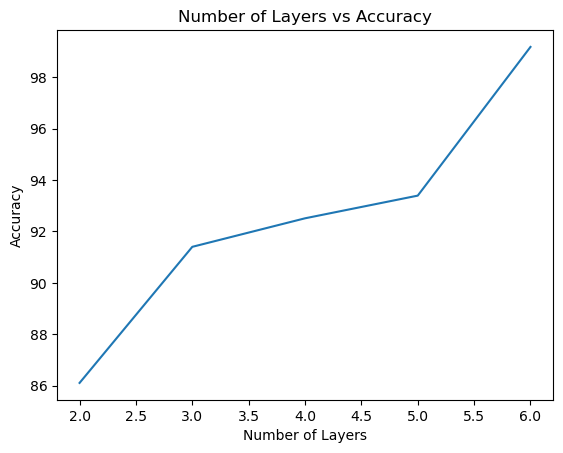

In [37]:
import matplotlib.pyplot as plt
step = np.linspace(2, 6, 5)
plt.plot(step,np.array(testAccList))

# Add title and axis names
plt.title('Number of Layers vs Accuracy')
plt.xlabel('Number of Layers')
plt.ylabel('Accuracy')
  
# Show graph
plt.show()